In [18]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import xgboost as xgb
import joblib
import eli5
from eli5.sklearn import PermutationImportance
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import cross_val_score, HalvingGridSearchCV
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler
from sklearn.svm import SVC
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.patches as patches  # extra code – for the curved arrow
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score, recall_score
import lightgbm as lgb
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_score, recall_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import warnings
from sklearn.model_selection import train_test_split
from lazypredict.Supervised import LazyClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.compose import make_column_selector, make_column_transformer


warnings.filterwarnings('ignore')

In [19]:
def pandas_preprocessing(X, y_present=True):
  X['PassengerId_split'] = X['PassengerId'].apply(lambda x : str(x).split(sep = '_', maxsplit=1))
  X['Group']= X['PassengerId_split'].apply(lambda x : np.nan if x[0] == 'nan' else x[0])
  X['Group_id']= X['PassengerId_split'].apply(lambda x : np.nan if x[0] == 'nan' else x[1])
  X = X.drop(['PassengerId','PassengerId_split'],axis=1)

  # Split the names
  X['Name_split'] = X['Name'].apply(lambda x : str(x).split(sep = ' ', maxsplit=1))
  X['Surname']= X['Name_split'].apply(lambda x : np.nan if x[0] == 'nan' else x[1])
  X = X.drop(['Name','Name_split'],axis=1)

  # Split the cabins
  X['Cabin_splt'] = X['Cabin'].apply(lambda x : str(x).split(sep = '/'))
  X['Deck']= X['Cabin_splt'].apply(lambda x : np.nan if x[0] == 'nan' else x[0])
  X['CabinNumber']= X['Cabin_splt'].apply(lambda x : np.nan if x[0] == 'nan' else x[1]).astype('float')
  X['CabinSide']= X['Cabin_splt'].apply(lambda x : np.nan if x[0] == 'nan' else x[2])
  X = X.drop(['Cabin','Cabin_splt'],axis=1)

  # Create Total
  numeric_cols = list(X.select_dtypes(include = np.number).columns)
  X['Total'] = sum(X[col] for col in numeric_cols if col not in ["Age", "CabinNumber"])
  # X['age'] = pd.cut(x=X['Age'], bins=range(0, 90, 10))
  # X['total'] = pd.cut(x=X['Total'], bins=[-35.987, 3598.7, 7197.4, 10796.1, 14394.8, 17993.5, 21592.2, 25190.9, 28789.6, 32388.3, 35987.])
  # X = X.drop(['Age', "Total"],axis=1)
  # X['age'] = X['age'].astype('str') 
  # X['total'] = X['total'].astype('str')
  target = X['Transported']
  target = target.astype(int)
  X = X.drop(['Transported'],axis=1)
  return X, target

In [20]:
bol_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    )

cat_pipeline = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
    )


num_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object)),
    (bol_pipeline, make_column_selector(dtype_include=bool)),
)

In [21]:
%matplotlib inline

In [22]:
df = pd.read_csv('data_FAA/train.csv')
df, y = pandas_preprocessing(df)
df_prepared = preprocessing.fit_transform(df)

In [23]:
df_prepared_fr = pd.DataFrame(
    df_prepared,
    columns=preprocessing.get_feature_names_out(),
    index=df.index)
df_prepared_fr.head()
X_train, X_test, y_train, y_test = train_test_split(df_prepared_fr, y, test_size = 0.2, random_state = 100)

In [24]:
import joblib
with open('data_FAA/data2.pkl', 'wb') as f:
    joblib.dump([X_train, y_train, X_test, y_test], f)

In [25]:
X_train, y_train, X_test, y_test = joblib.load('data_FAA/data2.pkl')
redo_grid_search = 1
cm = 0

In [26]:
if redo_grid_search:
  gridParams = {
      'learning_rate': [0.005, 0.01],
      'n_estimators': [8,16,24, 48, 96, 200],
      'num_leaves': [6,8,12,16, 32, 64], # large num_leaves helps improve accuracy but might lead to over-fitting
      'boosting_type' : ['gbdt', 'dart'], # for better accuracy -> try dart
      'objective' : ['binary'],
      'max_bin':[255, 510, 750, 900], # large max_bin helps improve accuracy but might slow down training progress
      'random_state' : [500],
      'colsample_bytree' : [0.64, 0.65, 0.66, 0.7],
      'subsample' : [0.7,0.75, 0.8],
      'reg_alpha' : [1,1.2, 1.4, 1.6],
      'reg_lambda' : [1,1.2,1.4, 1.6, 1.8],
      }

  # HalvingGridSearchCV
  grid_search_lbg = HalvingGridSearchCV(estimator=lgb.LGBMClassifier(),param_grid=gridParams,verbose = 1,
                                                            cv = 5,scoring='accuracy',max_resources=1000,random_state = 0,
                                                            resource='n_samples',n_jobs=-1).fit(X_train.values, y_train.values.ravel())

  lbg_best = grid_search_lbg.best_estimator_
  print("LGBM Classifer")
  print('LGBM Classifer Best Score',grid_search_lbg.best_score_)
  print('LGBM Classifer Best Parmas',grid_search_lbg.best_params_)
  print('LGBM Classifer Accuracy',cross_val_score(lbg_best,X_train.values, y_train.values.ravel(), cv=10).mean())
else:
  lbg_best = lgb.LGBMClassifier(metric="accuracy", max_bins=500, boosting="dart")

n_iterations: 4
n_required_iterations: 11
n_possible_iterations: 4
min_resources_: 20
max_resources_: 1000
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 138240
n_resources: 20
Fitting 5 folds for each of 138240 candidates, totalling 691200 fits
----------
iter: 1
n_candidates: 46080
n_resources: 60
Fitting 5 folds for each of 46080 candidates, totalling 230400 fits
----------
iter: 2
n_candidates: 15360
n_resources: 180
Fitting 5 folds for each of 15360 candidates, totalling 76800 fits
----------
iter: 3
n_candidates: 5120
n_resources: 540
Fitting 5 folds for each of 5120 candidates, totalling 25600 fits
LGBM Classifer
LGBM Classifer Best Score 0.7773797161647629
LGBM Classifer Best Parmas {'boosting_type': 'gbdt', 'colsample_bytree': 0.66, 'learning_rate': 0.01, 'max_bin': 255, 'n_estimators': 200, 'num_leaves': 8, 'objective': 'binary', 'random_state': 500, 'reg_alpha': 1, 'reg_lambda': 1.8, 'subsample': 0.7}
LGBM Classifer Accuracy 0.7919263210121558


In [27]:
y_pred = cross_val_predict(lbg_best, X_train, y_train, cv=20)
acc = accuracy_score(y_train, y_pred)
print(f"The accuracy score for this model is {acc}")

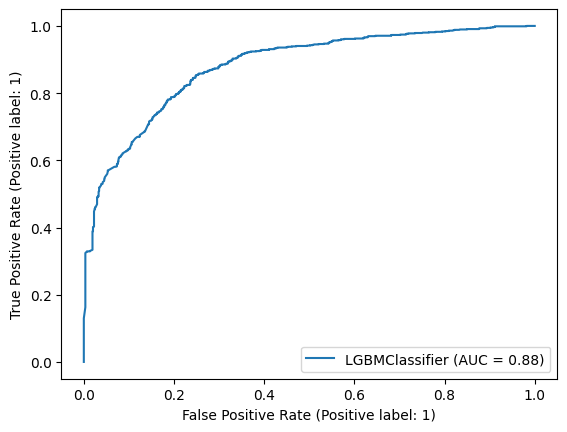

In [28]:
from sklearn.metrics import RocCurveDisplay
lbg_best.fit(X_train, y_train)
RocCurveDisplay.from_estimator(
   lbg_best, X_test, y_test)


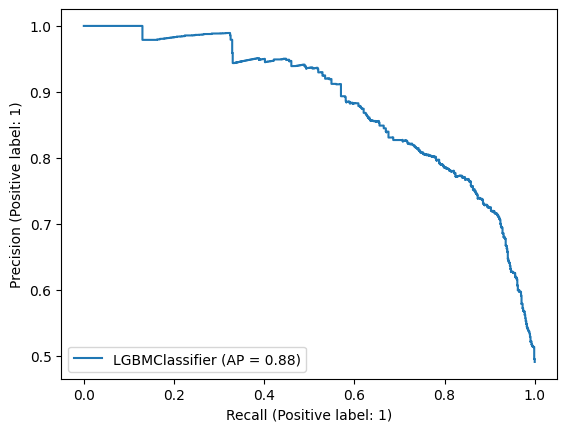

In [29]:
from sklearn.metrics import PrecisionRecallDisplay
PrecisionRecallDisplay.from_estimator(
   lbg_best, X_test, y_test)

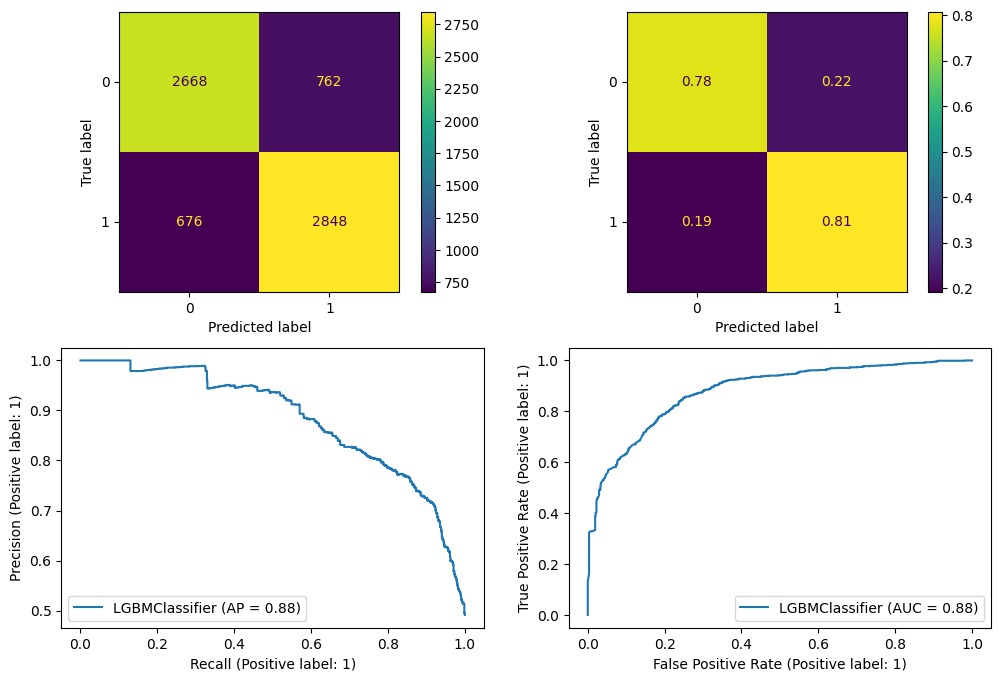

In [30]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 2, figsize=(12, 8))
RocCurveDisplay.from_estimator(
   lbg_best, X_test, y_test, ax=ax[1, 1])


PrecisionRecallDisplay.from_estimator(
   lbg_best, X_test, y_test, ax=ax[1, 0])

ConfusionMatrixDisplay.from_predictions(y_train, y_pred, ax=ax[0, 0])
ConfusionMatrixDisplay.from_predictions(y_train, y_pred, normalize="true", ax=ax[0, 1])
plt.show()

In [31]:
%%time

# always use same RANDOM_STATE k-folds for comparability between tests, reproducibility
RANDOMSTATE = 42
np.random.seed(RANDOMSTATE)

kfolds = KFold(n_splits=20, shuffle=True, random_state=RANDOMSTATE)

MEAN_RESPONSE=y_train.mean()
def cv_to_raw(cv_val, mean_response=MEAN_RESPONSE):
    return np.expm1(mean_response+cv_val) - np.expm1(mean_response)
	
scores = -cross_val_score(lbg_best, X_train, y_train,
                          scoring="neg_root_mean_squared_error",
                          cv=kfolds,
                          n_jobs=-1)
raw_scores = [cv_to_raw(x) for x in scores]
print("Raw CV RMSE %.0f (STD %.0f)" % (np.mean(raw_scores), np.std(raw_scores)))

Raw CV RMSE 1 (STD 0)
CPU times: user 56.3 ms, sys: 18.4 ms, total: 74.7 ms
Wall time: 810 ms


In [32]:
for score, name in zip(lbg_best.feature_importances_, X_train.columns):
    print(f"{score:.3f}{' ':>20}{name.split('__', 1)[1]:>20}")

54.000                                     Age
119.000                             RoomService
142.000                               FoodCourt
95.000                            ShoppingMall
192.000                                     Spa
173.000                                  VRDeck
49.000                             CabinNumber
94.000                                   Total
145.000                              HomePlanet
129.000                               CryoSleep
13.000                             Destination
0.000                                     VIP
54.000                                   Group
0.000                                Group_id
0.000                                 Surname
107.000                                    Deck
34.000                               CabinSide


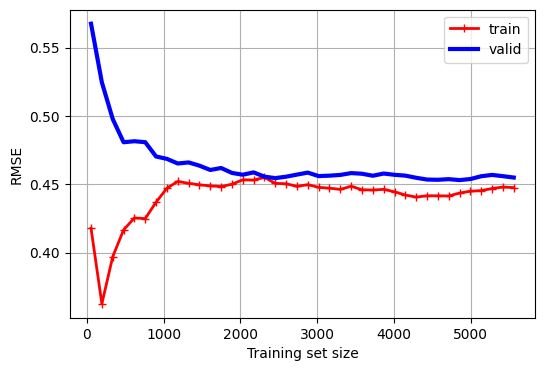

In [33]:
train_sizes, train_scores, valid_scores = learning_curve(
    lbg_best, X_train, y_train, train_sizes=np.linspace(0.01, 1.0, 40), cv=5,
    scoring="neg_root_mean_squared_error")
train_errors = -train_scores.mean(axis=1)
valid_errors = -valid_scores.mean(axis=1)

plt.figure(figsize=(6, 4))  # extra code – not needed, just formatting
plt.plot(train_sizes, train_errors, "r-+", linewidth=2, label="train")
plt.plot(train_sizes, valid_errors, "b-", linewidth=3, label="valid")

# extra code – beautifies and saves Figure 4–15
plt.xlabel("Training set size")
plt.ylabel("RMSE")
plt.grid()
plt.legend(loc="upper right")
# plt.axis([0, 1000, 0.3, 0.9])
# plt.save_fig("underfitting_learning_curves_plot")

plt.show()

In [ ]:
#----------------For submission----------------
data1= pd.read_csv("data_FAA/train.csv")
data2 = pd.read_csv("data_FAA/evaluation.csv")
data2 = pd.read_csv("data_FAA/evaluation.csv")
data2['Transported'] =-1

data1, y1 = pandas_preprocessing(data1)
data2, y2 = pandas_preprocessing(data2)

data1 = preprocessing.fit_transform(data1)
data2 = preprocessing.transform(data2)

lbg_best.fit(data1, y1)

pred = lbg_best.predict(data2)

pred = pred.astype(bool)
result=pd.read_csv('data_FAA/sample_submission.csv')
result['Transported'] = pred
result.to_csv('submission_lbgm_2.csv', index=False)